In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, \
                            confusion_matrix, plot_confusion_matrix

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

In [2]:
def visualize_data(x_num, y_num, X_trains, y_trains, group_names,
                   data_labels, save_path, size_x=20, size_y=20):
    """Odpowiada za wyświetlenie rozkładu danych w przystępnej formie dla różnych wersji przygotowanycj danych."""
    fig = plt.figure(figsize=(size_x, size_y))
    fig.subplots_adjust(hspace=0.10, wspace=0.1)
    
    for X, y, data_label, i in zip(X_trains, y_trains, data_labels, range(1, x_num*y_num+1)):
        ax = fig.add_subplot(x_num, y_num, i)
        counter = Counter(y)
        print(f'{data_label} - {counter}')
        for label, _ in counter.items():
            row_ix = np.where(y == label)[0]
            ax.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
        ax.legend(group_names)
        ax.set_title(f'Rozkład danych - {data_label}', fontsize=15)
    
    plt.savefig(save_path)
    plt.show()

In [3]:
data = pd.read_pickle(
    "../data/training_set/training_set.pkl")
bins = (-np.inf, 0, 20, 50, 100, np.inf)
group_names = [
    '1.brak', 
    '2.[1-20)', 
    '3.[20-50)', 
    '4.[50-100)', 
    '5.[100+]'
]
data['new_watchers'] = pd.cut(
    data['new_watchers'], bins=bins, labels=group_names)
data['new_watchers'].value_counts()

1.brak        1807749
3.[20-50)         835
2.[1-20)          802
4.[50-100)        612
5.[100+]          603
Name: new_watchers, dtype: int64

In [4]:
labels = LabelEncoder()
data['new_watchers'] = \
    labels.fit_transform(data['new_watchers'])
X = data.drop(['new_watchers'], axis=1)
y = data['new_watchers']

s = StandardScaler()
X = s.fit_transform(X)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.40, random_state=42)

### Metody wyrównania liczebności klas

In [5]:
X_trains = []
y_trains = []
data_labels = []

In [6]:
X_trains.append(X_train)
y_trains.append(y_train)
data_labels.append('brak usprawnień')

### 1. Oversampling - zwiększenie rozmiaru zbioru

In [7]:
oversample = SMOTE(random_state=42)
X_train_oversample, y_train_oversample = \
    oversample.fit_resample(X_train, y_train)

X_trains.append(X_train_oversample)
y_trains.append(y_train_oversample)
data_labels.append('oversampling')

### 2. Undersampling - zmniejszenie liczebności zbioru

In [8]:
undersample = RandomUnderSampler(random_state=42)
X_train_undersample, y_train_undersample = \
    undersample.fit_resample(X_train, y_train)

X_trains.append(X_train_undersample)
y_trains.append(y_train_undersample)
data_labels.append('undersampling')

### 3. Oversampling + undersampling

Ze względu na ogromną przewagę klasy zerowego przyrostu obserwujących nad pozostałymi, metoda oversamplingu sama w sobie nie daje dobrych rezultatów, ponieważ tworzy bardzo dużą ilość sztucznych danych. 

Analogicznie, undersampling bardzo zmniejsza rozmiar zbioru uczącego.

Wobec tego warto wypróbować podejście hybrydowe:

- najpierw oversampling do drugiej najliczniejszej klasy pomnożonej 10-ciokrotnie
- następnie undersampling klasy najbardziej licznej

In [9]:
n_samples = y_train.value_counts().nlargest(2).iloc[1] * 10

oversample = SMOTE(sampling_strategy={
                        1: n_samples, 2: n_samples, 
                        3: n_samples, 4: n_samples, 
                    }, random_state=42)
X_train_mix, y_train_mix = \
        oversample.fit_resample(X_train, y_train)

undersample = RandomUnderSampler(random_state=42)
X_train_mix, y_train_mix = \
    undersample.fit_resample(X_train_mix, y_train_mix)

X_trains.append(X_train_mix)
y_trains.append(y_train_mix)
data_labels.append('oversampling + undersampling')

brak usprawnień - Counter({0: 1084672, 2: 511, 1: 466, 3: 365, 4: 346})
oversampling - Counter({0: 1084672, 1: 1084672, 2: 1084672, 3: 1084672, 4: 1084672})
undersampling - Counter({0: 346, 1: 346, 2: 346, 3: 346, 4: 346})
oversampling + undersampling - Counter({0: 5110, 1: 5110, 2: 5110, 3: 5110, 4: 5110})


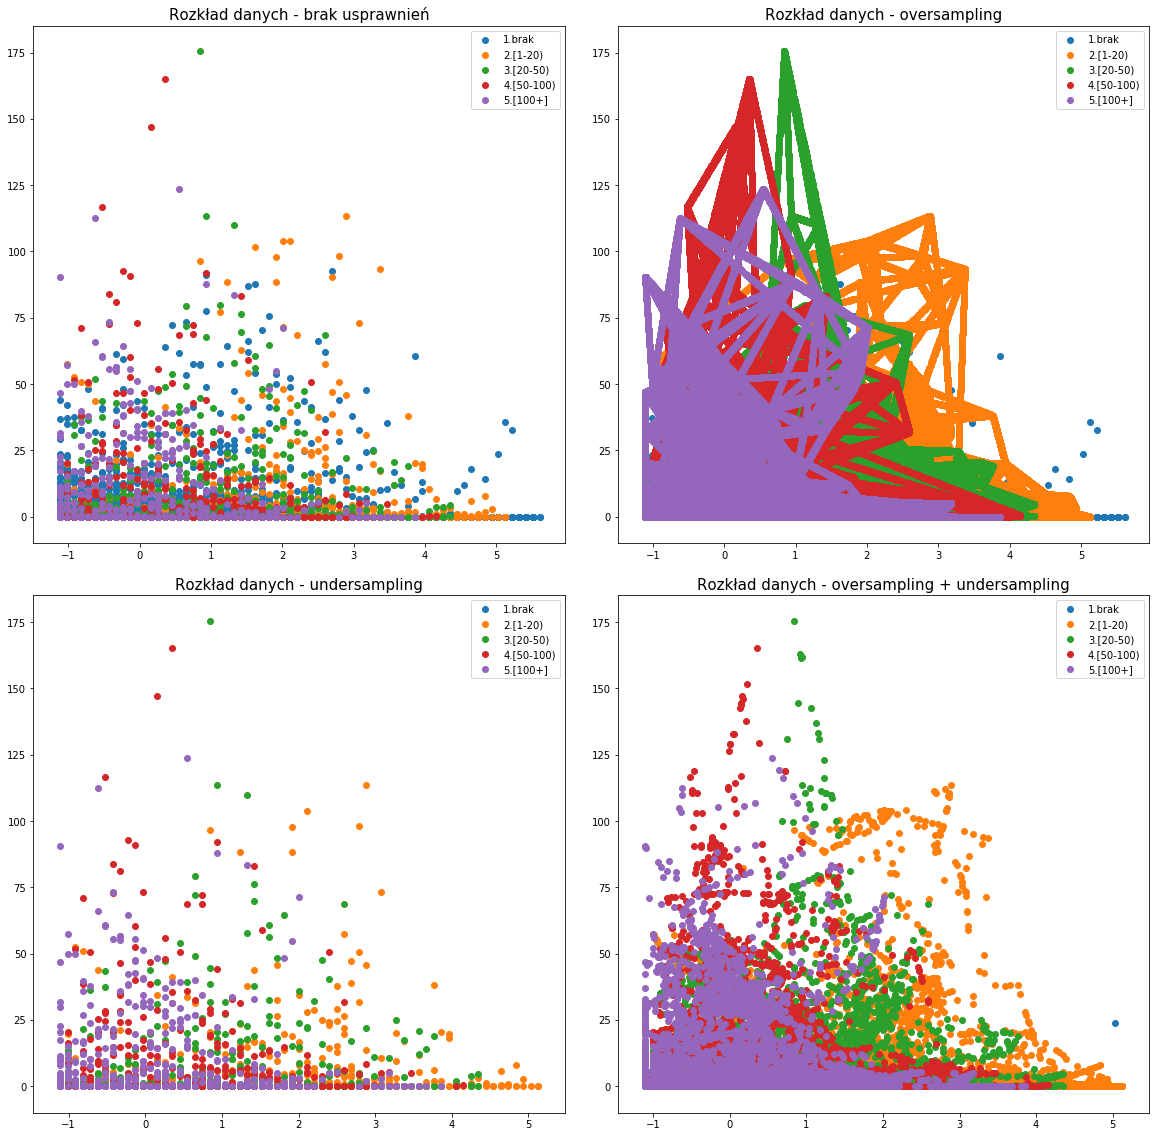

In [10]:
visualize_data(2, 2, X_trains, y_trains, group_names, data_labels, '../results/classification/rozkład danych.jpg')